In [1]:
import math
import torch
from torch import nn
import numpy as np
from datasets import *
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# 启用CUDA加速

In [2]:
class MyRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):

        super().__init__()
        self.hidden_size = hidden_size
        
        # 可学习参数的维度设置
        self.w_h = nn.Parameter(torch.rand(input_size, hidden_size))
        self.u_h = nn.Parameter(torch.rand(hidden_size, hidden_size))
        self.b_h = nn.Parameter(torch.zeros(hidden_size))
        
        self.w_y = nn.Parameter(torch.rand(hidden_size, output_size))
        self.b_y = nn.Parameter(torch.zeros(output_size))
        
        # 准备激活函数。Dropout函数可选。
        self.tanh = nn.Tanh()
        self.leaky_relu = nn.LeakyReLU()
        
        # 可选：使用性能更好的参数初始化函数
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)
                
    def forward(self, x):

        batch_size = x.size(0)
        seq_len = x.size(1)
        
        # 初始化隐藏状态，一般设为全0。由于是内部新建的变量，需要同步设备位置。
        h = torch.zeros(batch_size, self.hidden_size).to(x.device)
        # RNN实际上只能一步一步处理序列。因此需要用循环迭代。
        y_list = []
        for i in range(seq_len):
            h = self.tanh(torch.matmul(x[:, i, :], self.w_h) + 
                             torch.matmul(h, self.u_h) + self.b_h)  # (batch_size, hidden_size)
            y = self.leaky_relu(torch.matmul(h, self.w_y) + self.b_y)  # (batch_size, output_size)
            y_list.append(y)
        # 一般来说，RNN的返回值为最后一步的隐藏状态，以及每一步的输出状态。
        return torch.stack(y_list, dim=1), h

In [3]:
# 读取数据
TrafficData = TrafficDataset()
train_set, val_set, test_set = TrafficData.construct_set()
batch_size = 256
train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
val_loader = data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)
test_loader = data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)
input_size = train_set.X.shape[-1]
hidden_size = 6
output_size = 1
seq_len = 12
lr = 0.0001
epochs = 30
loss_func = nn.MSELoss()
my_rnn = MyRNN(input_size, hidden_size, output_size).to(device)
optimizer = torch.optim.Adam(my_rnn.parameters(), lr)

In [4]:
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_index = (y_true > 0)
    y_true = y_true[non_zero_index]
    y_pred = y_pred[non_zero_index]

    mape = np.abs((y_true - y_pred) / y_true)
    mape[np.isinf(mape)] = 0
    return np.mean(mape) * 100

In [5]:
from utils import *
train_loss_lst, val_loss_lst, train_score_lst, val_score_lst, stop_epoch = train(my_rnn, train_loader, val_loader, test_loader,
                                                       loss_func, TrafficData.denormalize, optimizer, epochs,
                                                       early_stop=10, device=device, output_model=None)

*** epoch1, train loss 0.0098, train rmse 107.6472, val loss 0.0031, val rmse 62.651231, time use 12.436s
*** epoch2, train loss 0.0025, train rmse 56.5353, val loss 0.0017, val rmse 45.868833, time use 7.813s
*** epoch3, train loss 0.0015, train rmse 44.5658, val loss 0.0013, val rmse 39.549745, time use 8.065s
*** epoch4, train loss 0.0013, train rmse 40.4039, val loss 0.0011, val rmse 36.872253, time use 7.383s
*** epoch5, train loss 0.0011, train rmse 37.9542, val loss 0.0010, val rmse 34.711287, time use 7.985s
*** epoch6, train loss 0.0010, train rmse 35.8660, val loss 0.0009, val rmse 32.731505, time use 7.959s
*** epoch7, train loss 0.0009, train rmse 33.8384, val loss 0.0008, val rmse 30.865488, time use 7.629s
*** epoch8, train loss 0.0008, train rmse 32.0767, val loss 0.0007, val rmse 29.358318, time use 7.720s
*** epoch9, train loss 0.0007, train rmse 30.7085, val loss 0.0007, val rmse 28.242627, time use 8.315s
*** epoch10, train loss 0.0007, train rmse 29.7970, val loss 0

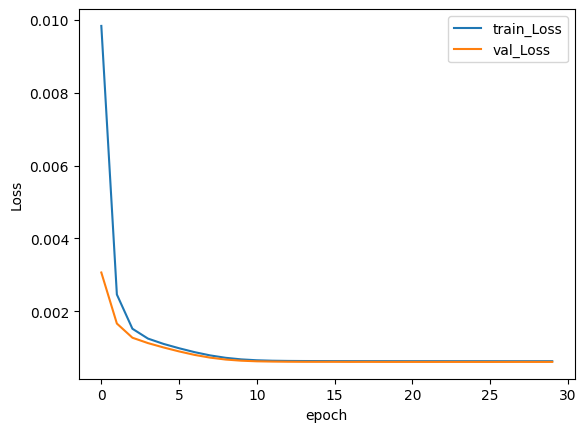

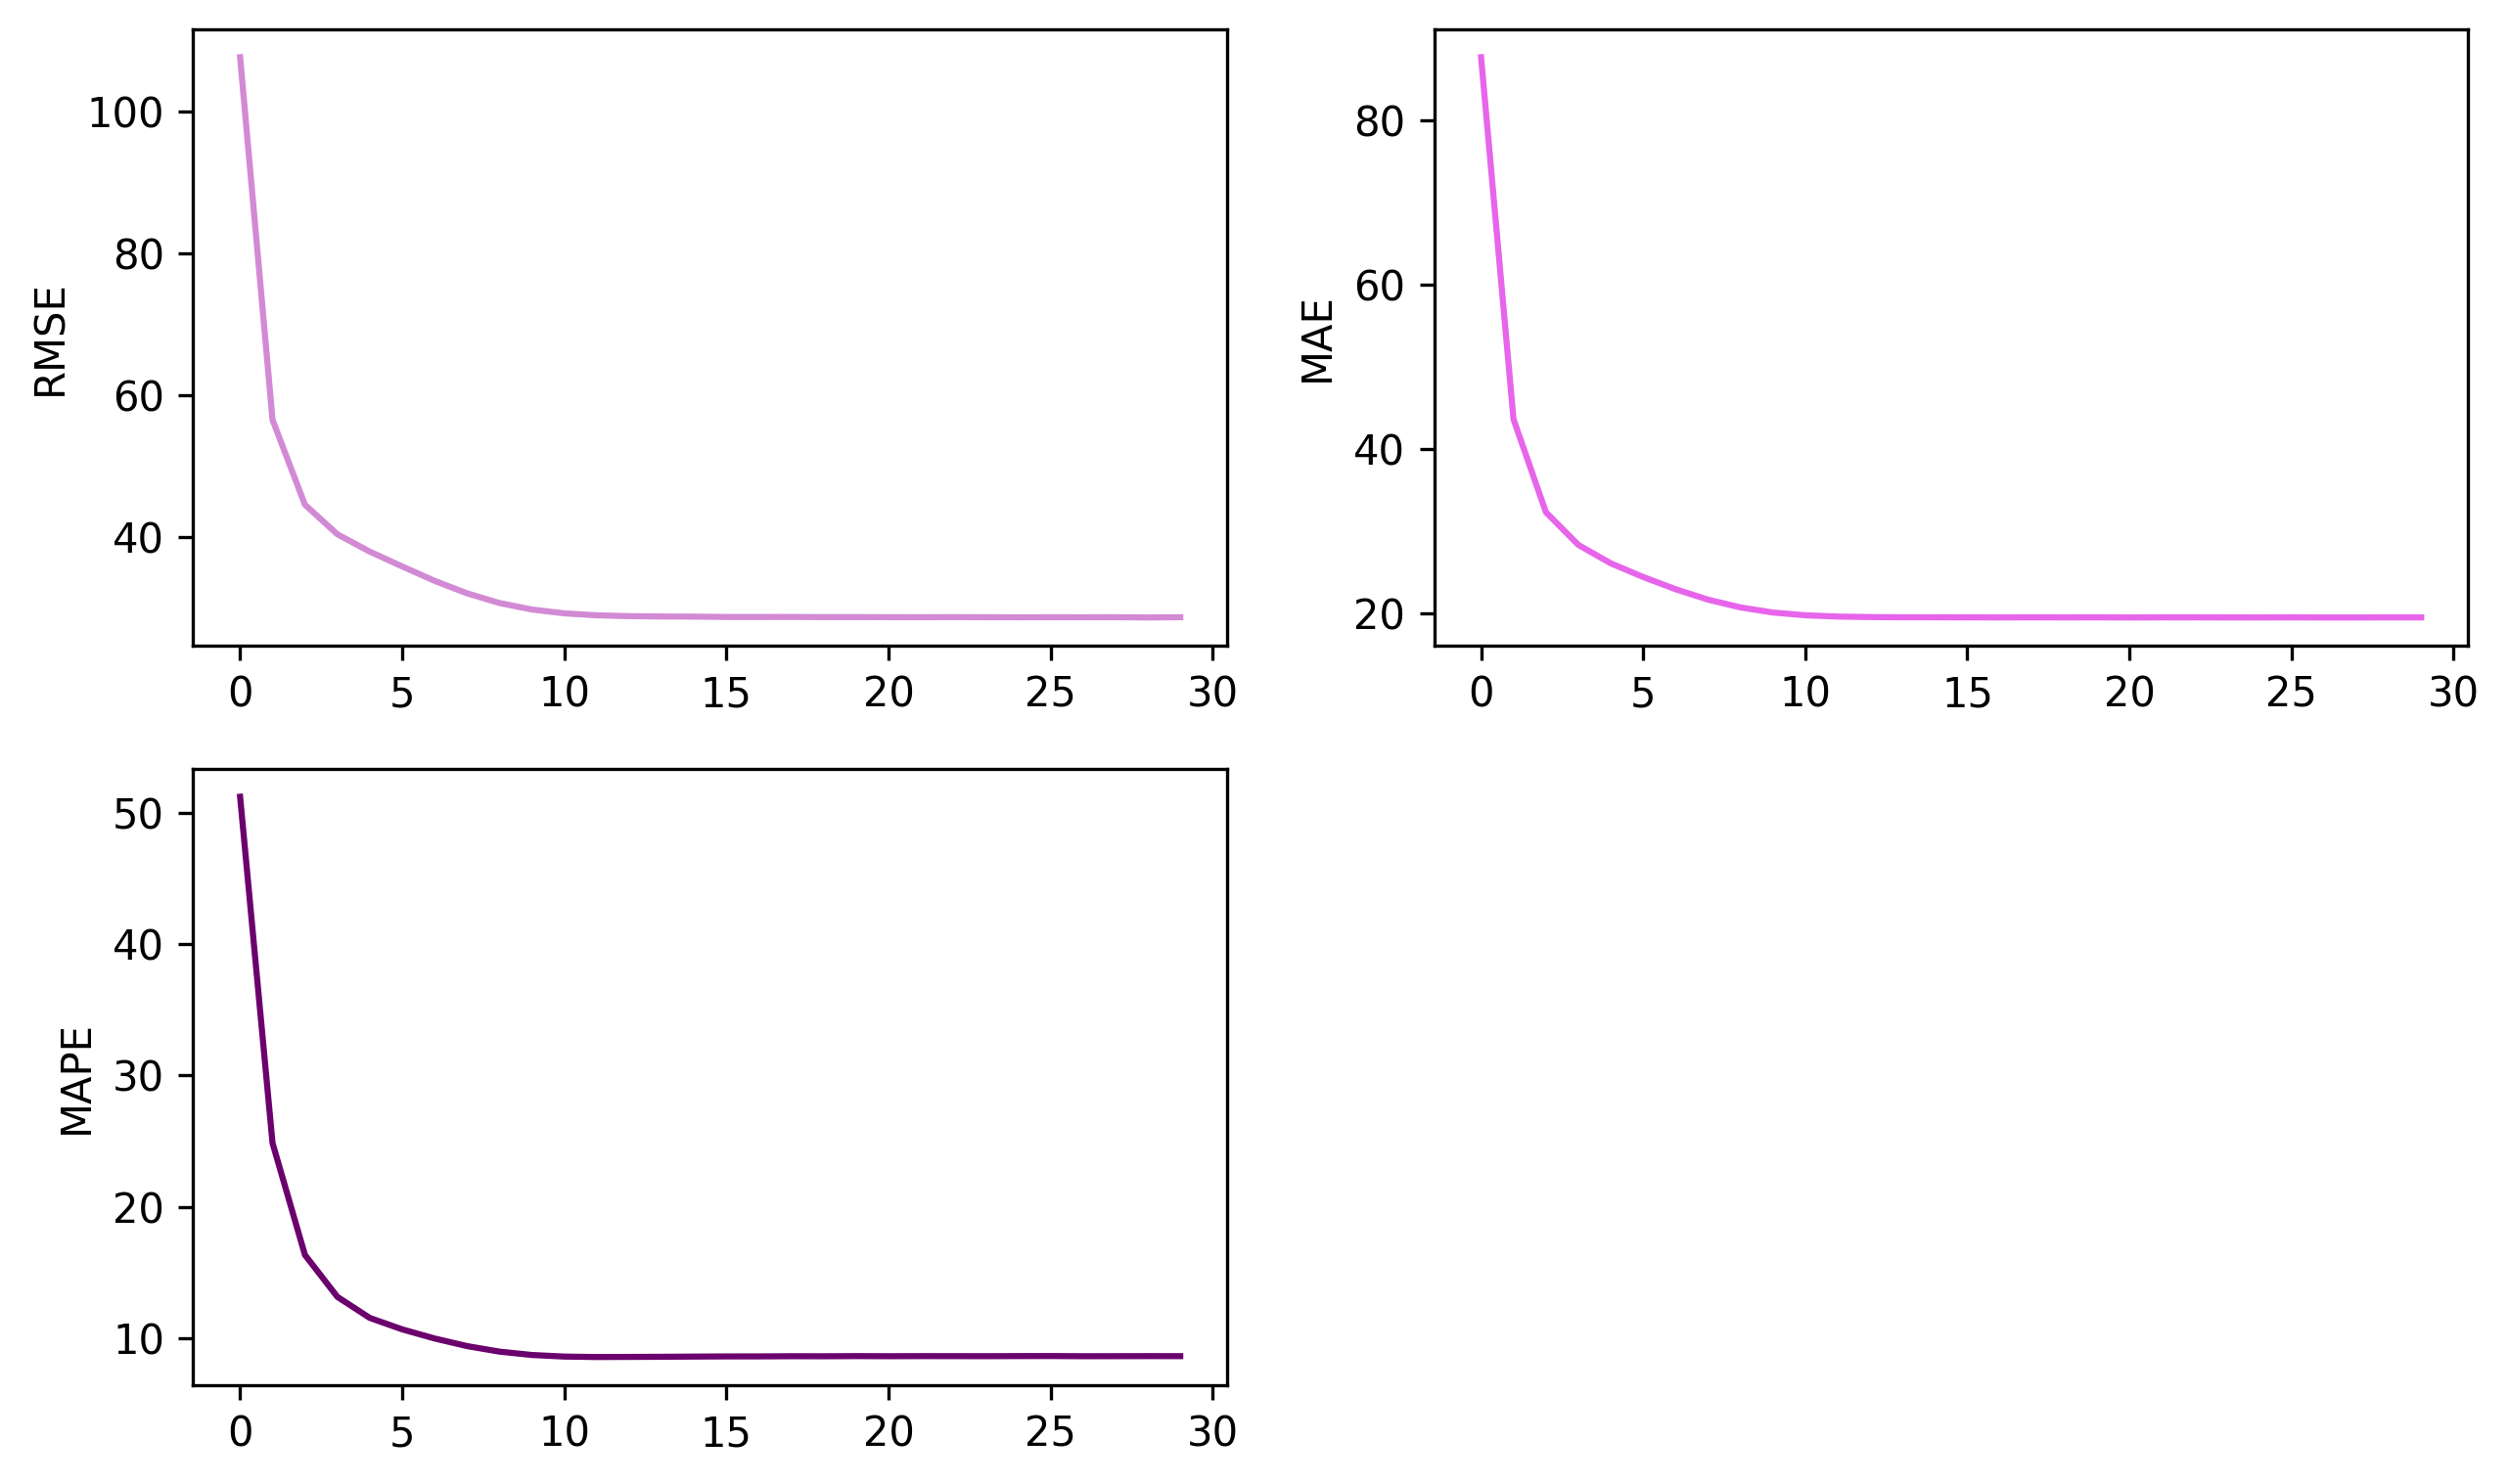

In [6]:
visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
plot_metric(train_score_lst)

In [7]:
# 超参数对比
hidden_size = 16 # 对比hidden_size
my_rnn = MyRNN(input_size, hidden_size, output_size).to(device)
optimizer = torch.optim.Adam(my_rnn.parameters(), lr)
train_loss_lst, val_loss_lst, train_score_lst, val_score_lst, stop_epoch = train(my_rnn, train_loader, val_loader, test_loader,
                                                       loss_func, TrafficData.denormalize, optimizer, epochs,
                                                       early_stop=10, device=device, output_model=None)
lr = 0.001 # 对比lr
hidden_size = 6 
my_rnn = MyRNN(input_size, hidden_size, output_size).to(device)
optimizer = torch.optim.Adam(my_rnn.parameters(), lr)
train_loss_lst, val_loss_lst, train_score_lst, val_score_lst, stop_epoch = train(my_rnn, train_loader, val_loader, test_loader,
                                                       loss_func, TrafficData.denormalize, optimizer, epochs,
                                                       early_stop=10, device=device, output_model=None)

*** epoch1, train loss 0.0095, train rmse 85.6680, val loss 0.0015, val rmse 41.238159, time use 8.145s
*** epoch2, train loss 0.0012, train rmse 39.0463, val loss 0.0010, val rmse 33.790220, time use 8.148s
*** epoch3, train loss 0.0009, train rmse 34.6740, val loss 0.0009, val rmse 31.569336, time use 8.198s
*** epoch4, train loss 0.0008, train rmse 32.8662, val loss 0.0008, val rmse 30.480059, time use 8.091s
*** epoch5, train loss 0.0008, train rmse 31.6434, val loss 0.0007, val rmse 29.186208, time use 8.096s
*** epoch6, train loss 0.0007, train rmse 30.7611, val loss 0.0007, val rmse 28.486964, time use 8.088s
*** epoch7, train loss 0.0007, train rmse 30.1269, val loss 0.0007, val rmse 27.951327, time use 8.087s
*** epoch8, train loss 0.0007, train rmse 29.6365, val loss 0.0006, val rmse 27.614768, time use 8.131s
*** epoch9, train loss 0.0007, train rmse 29.3274, val loss 0.0006, val rmse 27.456140, time use 8.023s
*** epoch10, train loss 0.0007, train rmse 29.0905, val loss 0.0

In [8]:
from utils import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = train_set.X.shape[-1]
hidden_size = 6
output_size = 1
seq_len = 12
lr = 0.0001
epochs = 30
loss_func = nn.MSELoss()

nn_rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True).to(device)
out_linear = nn.Sequential(nn.Linear(hidden_size, 1), nn.LeakyReLU()).to(device)

optimizer = torch.optim.Adam(list(nn_rnn.parameters()) + list(out_linear.parameters()), lr)

train_loss_lst, val_loss_lst, train_score_lst, val_score_lst, stop_epoch = train(nn_rnn, train_loader, val_loader, test_loader,
                                                       loss_func, TrafficData.denormalize, optimizer, epochs,
                                                       early_stop=10, device=device, output_model=out_linear)

*** epoch1, train loss 0.0391, train rmse 207.8412, val loss 0.0115, val rmse 120.646613, time use 3.480s
*** epoch2, train loss 0.0079, train rmse 99.8246, val loss 0.0026, val rmse 57.380657, time use 2.395s
*** epoch3, train loss 0.0013, train rmse 40.9627, val loss 0.0010, val rmse 34.655747, time use 1.974s
*** epoch4, train loss 0.0010, train rmse 35.5610, val loss 0.0009, val rmse 32.458925, time use 2.386s
*** epoch5, train loss 0.0009, train rmse 33.4835, val loss 0.0008, val rmse 30.752608, time use 2.480s
*** epoch6, train loss 0.0008, train rmse 31.9238, val loss 0.0007, val rmse 29.485629, time use 2.091s
*** epoch7, train loss 0.0007, train rmse 30.8915, val loss 0.0007, val rmse 28.668238, time use 2.672s
*** epoch8, train loss 0.0007, train rmse 30.2172, val loss 0.0007, val rmse 28.127940, time use 1.965s
*** epoch9, train loss 0.0007, train rmse 29.8046, val loss 0.0007, val rmse 27.818713, time use 2.388s
*** epoch10, train loss 0.0007, train rmse 29.5150, val loss 0

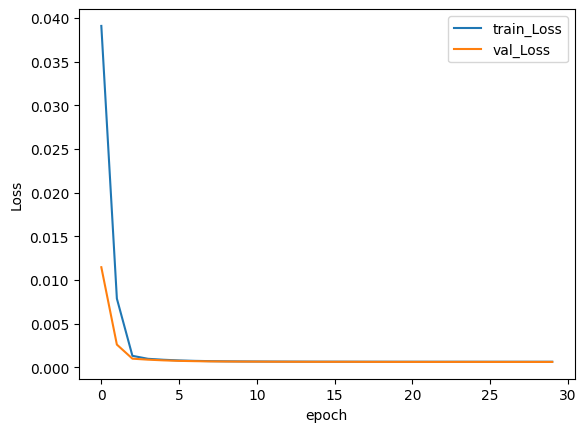

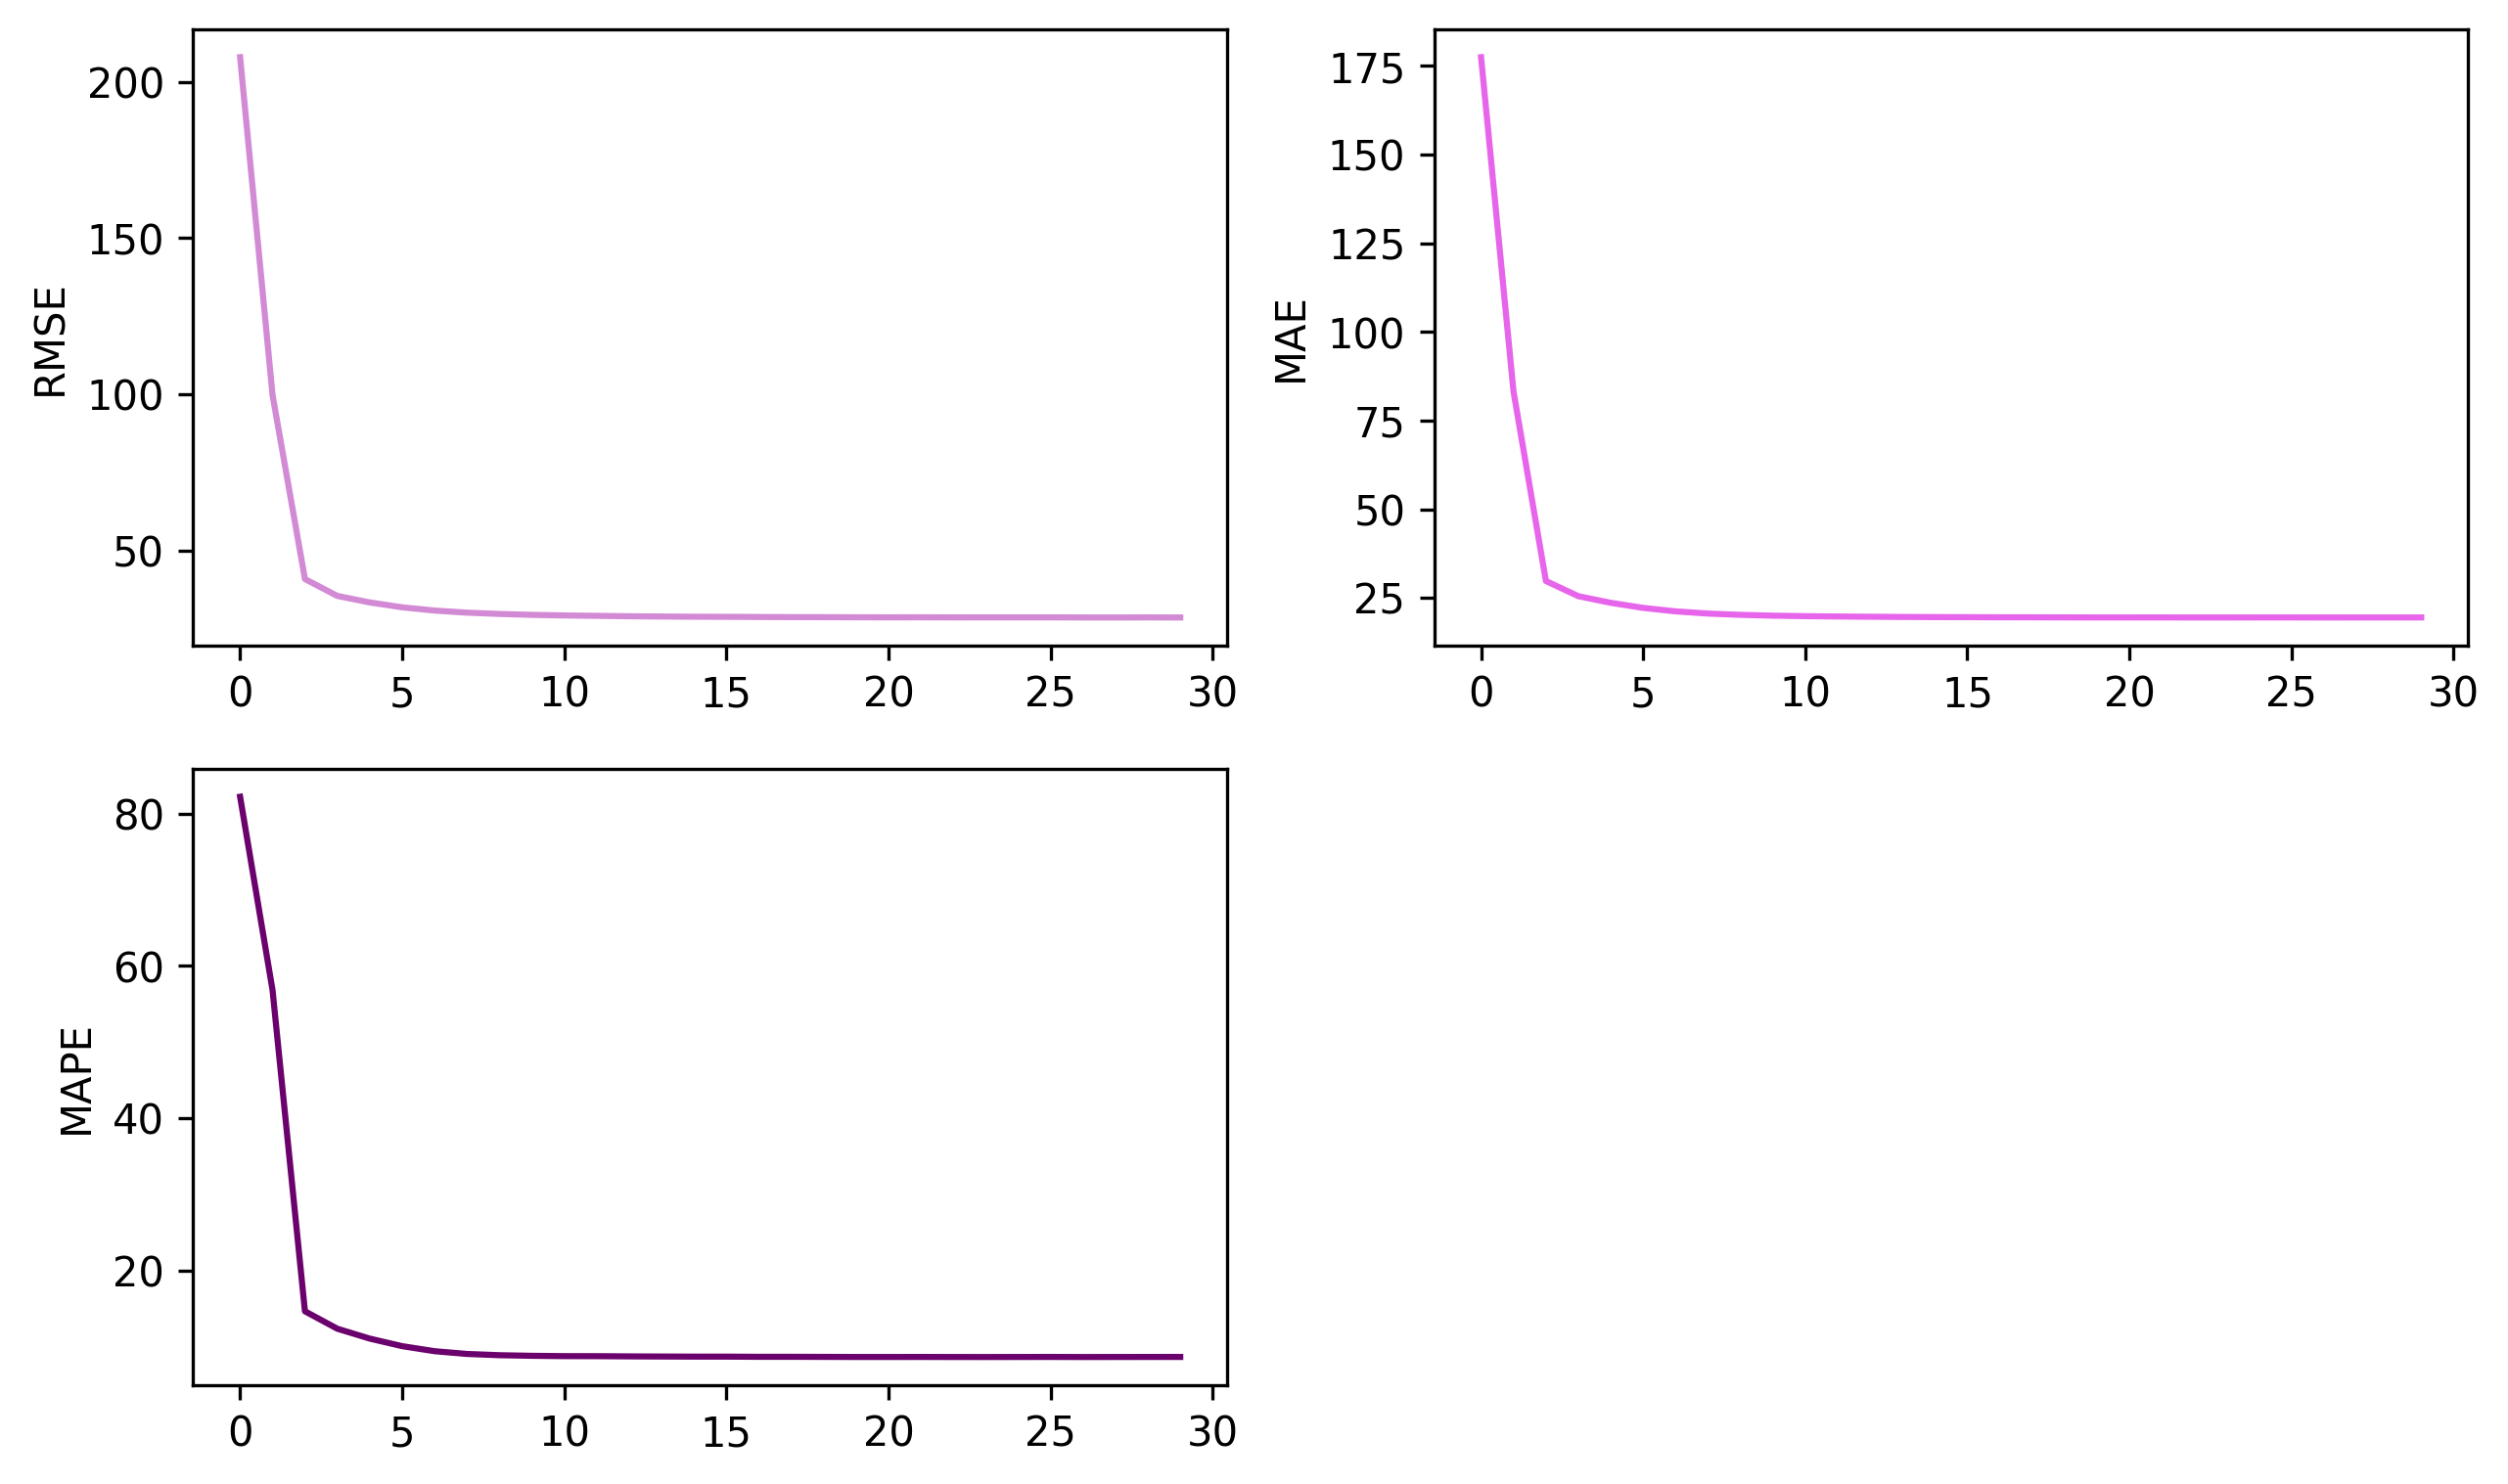

In [9]:
visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
plot_metric(train_score_lst)

In [12]:
# 超参数对比
hidden_size = 16 # 对比hidden_size
nn_rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True).to(device)
out_linear = nn.Sequential(nn.Linear(hidden_size, 1), nn.LeakyReLU()).to(device)
optimizer = torch.optim.Adam(list(nn_rnn.parameters()) + list(out_linear.parameters()), lr)
train_loss_lst, val_loss_lst, train_score_lst, val_score_lst, stop_epoch = train(nn_rnn, train_loader, val_loader, test_loader,
                                                       loss_func, TrafficData.denormalize, optimizer, epochs,
                                                       early_stop=10, device=device, output_model=out_linear)
hidden_size = 6
lr = 0.001 #对比lr
nn_rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True).to(device)
out_linear = nn.Sequential(nn.Linear(hidden_size, 1), nn.LeakyReLU()).to(device)
optimizer = torch.optim.Adam(list(nn_rnn.parameters()) + list(out_linear.parameters()), lr)
train_loss_lst, val_loss_lst, train_score_lst, val_score_lst, stop_epoch = train(nn_rnn, train_loader, val_loader, test_loader,
                                                       loss_func, TrafficData.denormalize, optimizer, epochs,
                                                       early_stop=10, device=device, output_model=out_linear)

*** epoch1, train loss 0.0102, train rmse 98.6915, val loss 0.0009, val rmse 32.108572, time use 2.841s
*** epoch2, train loss 0.0009, train rmse 33.6255, val loss 0.0008, val rmse 30.890648, time use 2.520s
*** epoch3, train loss 0.0008, train rmse 32.3021, val loss 0.0008, val rmse 29.775097, time use 2.681s
*** epoch4, train loss 0.0007, train rmse 31.1261, val loss 0.0007, val rmse 28.748631, time use 2.718s
*** epoch5, train loss 0.0007, train rmse 30.2006, val loss 0.0007, val rmse 28.034854, time use 2.500s
*** epoch6, train loss 0.0007, train rmse 29.5724, val loss 0.0006, val rmse 27.630256, time use 2.631s
*** epoch7, train loss 0.0007, train rmse 29.2295, val loss 0.0006, val rmse 27.313374, time use 2.992s
*** epoch8, train loss 0.0006, train rmse 29.0501, val loss 0.0006, val rmse 27.471819, time use 2.476s
*** epoch9, train loss 0.0006, train rmse 28.9305, val loss 0.0006, val rmse 27.160724, time use 3.413s
*** epoch10, train loss 0.0006, train rmse 28.8585, val loss 0.0